In [1]:
!pip install torch torchvision matplotlib plotly torchviz opencv-python pytorch-gradcam grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 98.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=48ce99a56abe2ae6bb921f8aece15ef42ffeef854d2c557284a5c53cc0887c44
  Stored in directory: /root/.cache/pip/wheels/20/d6/4e/1ac02c54faee563b4d06015456c6c5d85550dcec878740f37d
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39647 sha256=725cdcb6638e31dd94940a4610503c12b8fdba04a7f6a982fa05a2e0475537cc
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built pytorch-gradcam grad-cam


In [2]:
!pip install kaggle


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramaree","key":"37ff6f64821251544abeae7000af5d72"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
100% 657M/658M [00:30<00:00, 20.7MB/s]
100% 658M/658M [00:30<00:00, 22.9MB/s]


In [6]:
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import os
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from torch.optim.lr_scheduler import ReduceLROnPlateau
import logging
import cv2

In [8]:
# Set up logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO,
                   format='%(asctime)s - %(message)s')


In [9]:

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Warning: Skipping problematic image at {img_path}")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [11]:

def visualize_model(model, device):
    sample_input = torch.randn(1, 3, 128, 128).to(device)

    print("Model Architecture Visualization:")
    print("\nConvolutional Layers:")
    x = sample_input

    for i, layer in enumerate(model.conv_layers):
        x = layer(x)
        print(f"Layer {i}: {layer.__class__.__name__} -> Output shape: {x.shape}")

    print("\nFully Connected Layers:")
    x = x.view(x.size(0), -1)

    for i, layer in enumerate(model.fc_layers):
        x = layer(x)
        print(f"Layer {i}: {layer.__class__.__name__} -> Output shape: {x.shape}")


In [12]:
def visualize_grad_cam(model, image, label, device, class_names):
    model.eval()

    target_layer = model.conv_layers[-2]  # Choose the layer to visualize
    activations = None
    gradients = None

    def save_activation(module, input, output):
        nonlocal activations
        activations = output

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    handle1 = target_layer.register_forward_hook(save_activation)
    handle2 = target_layer.register_backward_hook(save_gradient)

    output = model(image.unsqueeze(0).to(device))
    pred = output.argmax(dim=1).item()

    model.zero_grad()
    class_loss = output[0, pred]
    class_loss.backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap /= torch.max(heatmap)

    heatmap = heatmap.detach().cpu().numpy()
    heatmap = cv2.resize(heatmap, (128, 128))

    img = image.cpu().numpy().transpose(1, 2, 0)
    img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
    img = img.astype(np.uint8)

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(heatmap)
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    ax3.imshow(superimposed_img)
    ax3.set_title('Superimposed')
    ax3.axis('off')

    plt.suptitle(f'True: {class_names[label.item()]}\nPredicted: {class_names[pred]}')
    plt.show()

    handle1.remove()
    handle2.remove()


In [13]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [14]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, lr_history):
    fig = make_subplots(rows=3, cols=1, subplot_titles=('Loss', 'Accuracy', 'Learning Rate'))

    # Plot losses
    fig.add_trace(go.Scatter(y=train_losses, name='Training Loss', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(y=val_losses, name='Validation Loss', line=dict(color='orange')), row=1, col=1)

    # Plot accuracies
    fig.add_trace(go.Scatter(y=train_accuracies, name='Training Accuracy', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(y=val_accuracies, name='Validation Accuracy', line=dict(color='orange')), row=2, col=1)

    # Plot learning rate
    fig.add_trace(go.Scatter(y=lr_history, name='Learning Rate', line=dict(color='green')), row=3, col=1)

    fig.update_layout(height=900, width=800, title_text='Training Metrics')
    fig.show()

In [15]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [16]:
def evaluate_model(model, test_loader, criterion, device, class_names):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    conf_matrix = confusion_matrix(all_labels, all_preds)
    classification_rep = classification_report(all_labels, all_preds, target_names=class_names)

    return test_loss, test_accuracy, classification_rep, conf_matrix


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=7, verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * correct / total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        # Learning rate scheduling
        scheduler.step(val_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
        print('--------------------')

        logging.info(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, '
                    f'Train Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, '
                    f'Val Acc: {val_epoch_acc:.2f}%')

        if val_epoch_acc > best_val_accuracy:
            best_val_accuracy = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [18]:
def predict_disease(image_path, model_path, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model = CNNClassifier(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence = predicted_prob.item() * 100

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Disease: {predicted_class}\nConfidence: {confidence:.2f}%')
    plt.show()

    top_probs, top_indices = torch.topk(probabilities, 3)
    print("\nTop 3 Predictions:")
    for i in range(3):
        print(f"{class_names[top_indices[0][i]]}: {top_probs[0][i]*100:.2f}%")

    return predicted_class, confidence


In [19]:
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = CustomImageDataset(root_dir='/content/PlantVillage',
                          transform=train_transform)

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Initialize model, criterion, and optimizer
num_classes = len(dataset.classes)
model = CNNClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Visualize model architecture
visualize_model(model, device)


Using device: cuda
Model Architecture Visualization:

Convolutional Layers:
Layer 0: Conv2d -> Output shape: torch.Size([1, 32, 128, 128])
Layer 1: ReLU -> Output shape: torch.Size([1, 32, 128, 128])
Layer 2: BatchNorm2d -> Output shape: torch.Size([1, 32, 128, 128])
Layer 3: MaxPool2d -> Output shape: torch.Size([1, 32, 64, 64])
Layer 4: Conv2d -> Output shape: torch.Size([1, 64, 64, 64])
Layer 5: ReLU -> Output shape: torch.Size([1, 64, 64, 64])
Layer 6: BatchNorm2d -> Output shape: torch.Size([1, 64, 64, 64])
Layer 7: MaxPool2d -> Output shape: torch.Size([1, 64, 32, 32])
Layer 8: Conv2d -> Output shape: torch.Size([1, 128, 32, 32])
Layer 9: ReLU -> Output shape: torch.Size([1, 128, 32, 32])
Layer 10: BatchNorm2d -> Output shape: torch.Size([1, 128, 32, 32])
Layer 11: MaxPool2d -> Output shape: torch.Size([1, 128, 16, 16])
Layer 12: Conv2d -> Output shape: torch.Size([1, 256, 16, 16])
Layer 13: ReLU -> Output shape: torch.Size([1, 256, 16, 16])
Layer 14: BatchNorm2d -> Output shape:

In [21]:
# Train the model
num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

Epoch [1/50]
Train Loss: 0.8819, Train Acc: 73.10%
Val Loss: 0.5542, Val Acc: 82.00%
--------------------
Epoch [2/50]
Train Loss: 0.7067, Train Acc: 78.38%
Val Loss: 0.6682, Val Acc: 80.55%
--------------------
EarlyStopping counter: 1 out of 7
Epoch [3/50]
Train Loss: 0.5930, Train Acc: 82.19%
Val Loss: 0.4406, Val Acc: 85.95%
--------------------
Epoch [4/50]
Train Loss: 0.5315, Train Acc: 83.91%
Val Loss: 0.6321, Val Acc: 81.87%
--------------------
EarlyStopping counter: 1 out of 7
Epoch [5/50]
Train Loss: 0.4847, Train Acc: 84.98%
Val Loss: 0.3341, Val Acc: 89.34%
--------------------
Epoch [6/50]
Train Loss: 0.4204, Train Acc: 86.90%
Val Loss: 0.3602, Val Acc: 89.56%
--------------------
EarlyStopping counter: 1 out of 7
Epoch [7/50]
Train Loss: 0.3861, Train Acc: 88.29%
Val Loss: 0.2440, Val Acc: 92.89%
--------------------
Epoch [8/50]
Train Loss: 0.3854, Train Acc: 88.25%
Val Loss: 0.2248, Val Acc: 92.50%
--------------------
Epoch [9/50]
Train Loss: 0.3356, Train Acc: 89.95%

In [22]:
# Plot training curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, [])


In [23]:
# Evaluate the model
test_loss, test_accuracy, classification_rep, conf_matrix = evaluate_model(
    model, test_loader, criterion, device, dataset.classes
)
print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("\nClassification Report:")
print(classification_rep)


Test Results:
Test Loss: 0.0552
Test Accuracy: 98.71%

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      1.00      0.98       155
                     Pepper__bell___healthy       1.00      1.00      1.00       215
                      Potato___Early_blight       0.99      1.00      1.00       152
                       Potato___Late_blight       1.00      0.96      0.98       147
                           Potato___healthy       1.00      1.00      1.00        24
                      Tomato_Bacterial_spot       0.98      0.99      0.99       336
                        Tomato_Early_blight       0.93      0.97      0.95       144
                         Tomato_Late_blight       0.99      0.98      0.98       269
                           Tomato_Leaf_Mold       1.00      0.98      0.99       151
                  Tomato_Septoria_leaf_spot       1.00      0.98      

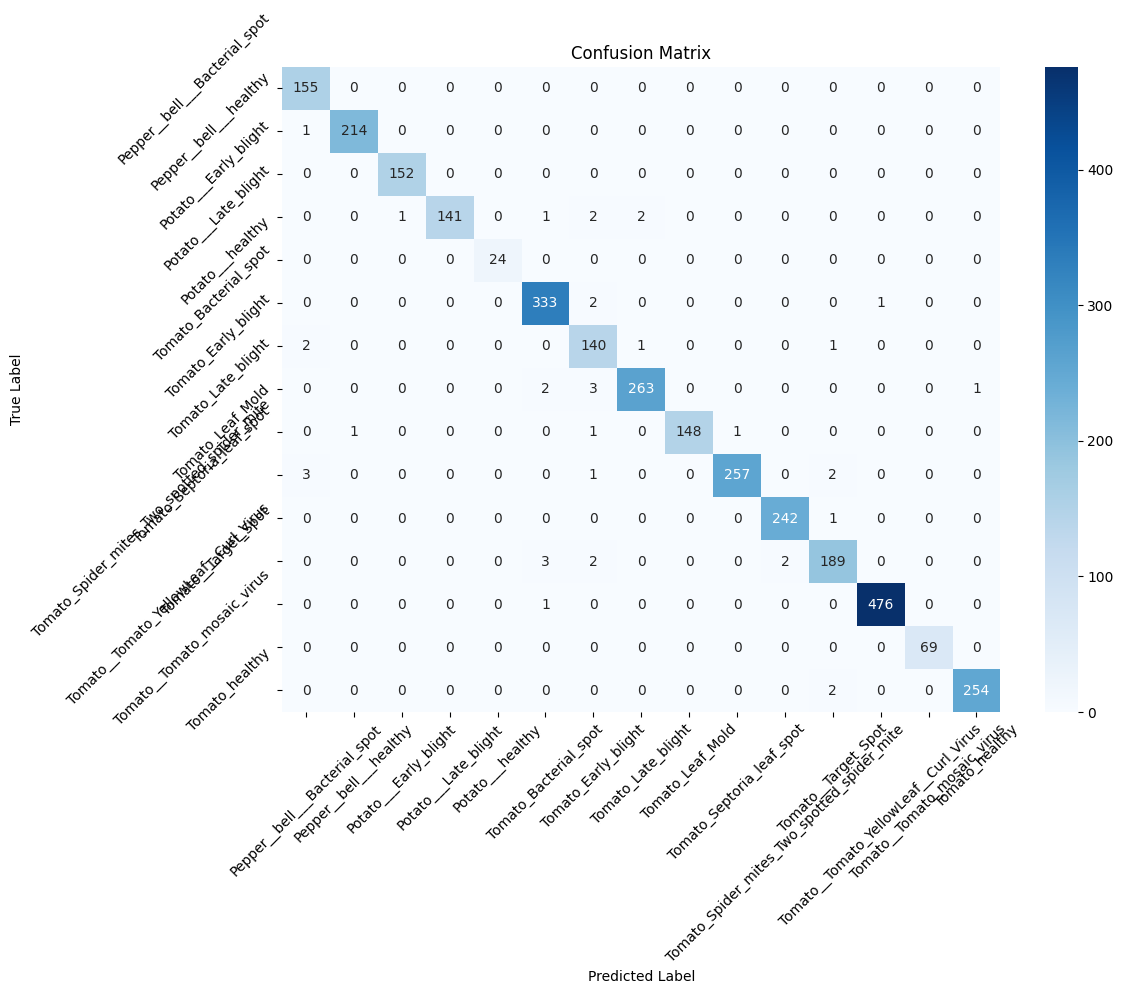

In [24]:
# Plot confusion matrix
plot_confusion_matrix(conf_matrix, dataset.classes)


In [25]:
# Save the model
torch.save(model.state_dict(), 'final_model.pth')
print("\nTraining completed. Model saved as 'final_model.pth'")



Training completed. Model saved as 'final_model.pth'


<ipython-input-18-8f3978448be4>:15: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



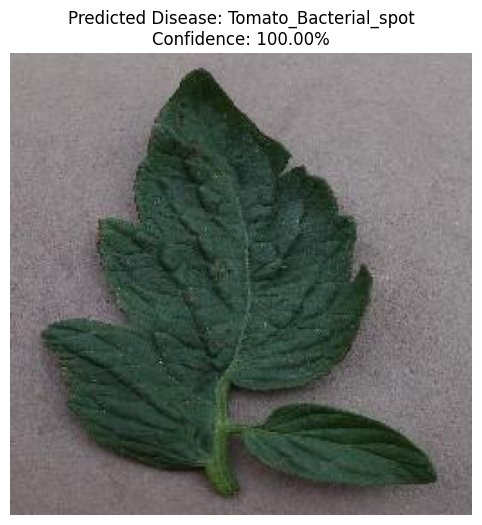


Top 3 Predictions:
Tomato_Bacterial_spot: 100.00%
Tomato_Early_blight: 0.00%
Tomato__Tomato_YellowLeaf__Curl_Virus: 0.00%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



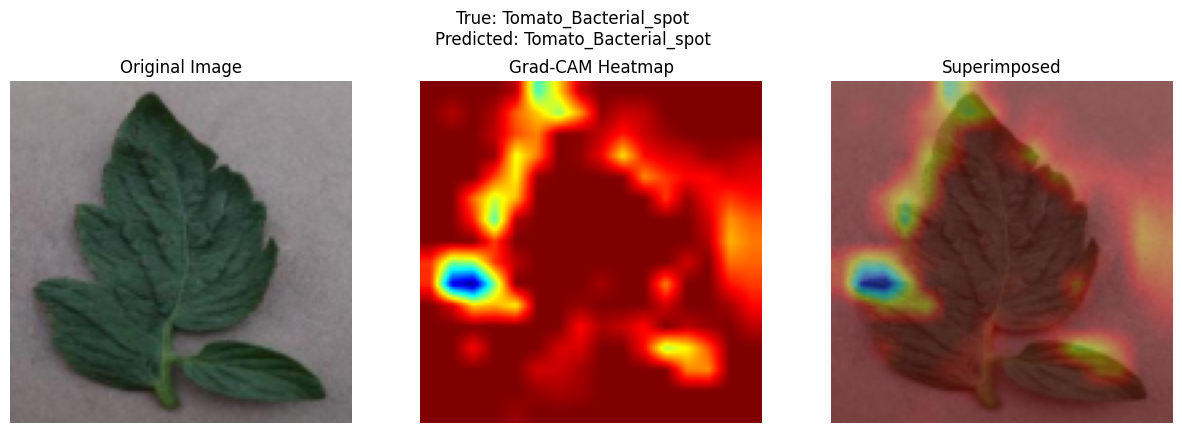

In [26]:
# Make a prediction on a sample image
sample_image_path = '/content/PlantVillage/Tomato_Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG'  # Change this to your image path
predicted_class, confidence = predict_disease(sample_image_path, 'final_model.pth', dataset.classes)

# Load the image for Grad-CAM visualization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

image = Image.open(sample_image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Visualize Grad-CAM
visualize_grad_cam(model, image_tensor.squeeze(0), torch.tensor(dataset.class_to_idx[predicted_class]), device, dataset.classes)

